# Spring's constant measuring

TODO:
analyze dinamic dataset
create the plots
get the coefficients with linear regression
use chi2 to see if its correct

## Importing libraries

In [744]:
import sys

print(sys.executable)

/Users/mattiaballico/Documents/Programmazione/Università/AnalisiDati/.venv/bin/python


In [745]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.signal as spy
import scipy.stats as stat
import math

from typing import Dict, List

## Loading data

### reading filenames

In [746]:
data_dir = "./data"

csv_data = []
excel_data = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        current_file_path = os.path.join(root, file).replace(
            "\\", "/"
        )  # fix the unbearably frustrating flaws of the wanna-be OS... "Windows"
        if "xlsx" in file:
            excel_data.append(current_file_path)
        elif "csv" in file:
            csv_data.append(current_file_path)
    break

del root, dirs, files, current_file_path, data_dir

### functions to read the files

In [747]:
def read_csv(filename: str):
    data = pd.read_csv(filename, sep=";").replace(",", ".", regex=True)

    data.dropna(inplace=True)
    data.drop(
        index=data.index[0], axis=0, inplace=True
    )  # instrument error causes first value to be nonsensical

    for col in data.columns:
        data[col] = data[col].apply(pd.to_numeric)

    return data


def read_excel(filename: str):
    data = pd.read_excel(filename)
    return data

### Load the datasets to a dict

In [748]:
datasets = dict()

for file in csv_data + excel_data:
    key = os.path.basename(file).split(".")[0]
    if "csv" in file:
        datasets[key] = read_csv(file)
    elif "xlsx" in file:
        datasets[key] = read_excel(file)

for k in datasets.keys():
    print(f"\nkey: {k}")
    datasets[k].info()

del k, key, file, csv_data, excel_data


key: sonar_non-pretensionata_statico
<class 'pandas.core.frame.DataFrame'>
Index: 1027 entries, 1 to 1027
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Position (mm) Run #1  1027 non-null   float64
 1   Position (mm) Run #2  1027 non-null   float64
 2   Position (mm) Run #3  1027 non-null   float64
 3   Position (mm) Run #4  1027 non-null   float64
 4   Position (mm) Run #5  1027 non-null   float64
 5   Position (mm) Run #6  1027 non-null   float64
dtypes: float64(6)
memory usage: 56.2 KB

key: sonar_pretensionata_statico
<class 'pandas.core.frame.DataFrame'>
Index: 1029 entries, 1 to 1029
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Position (mm) Run #1  1029 non-null   float64
 1   Position (mm) Run #2  1029 non-null   float64
 2   Position (mm) Run #3  1029 non-null   float64
 3   Position (mm) Run

In [749]:
# sampling frequencies in Hz

static_sampling_frequency = 100
dynamic_sampling_frequency = 200

In [750]:
static_keys = list(filter(lambda k: "statico" in k, datasets.keys()))
dynamic_keys = list(filter(lambda k: "dinamico" in k, datasets.keys()))


static_datasets = {k: datasets[k] for k in static_keys}
dynamic_datasets = {k: datasets[k] for k in dynamic_keys}

del static_keys, dynamic_keys

In [751]:
object_masses = dict()
ds = datasets["misure_masse"]
objects = [str(e) for e in ds.iloc[:, 0].array.tolist()]
masses = ds.iloc[:, 1].array.tolist()

for i in range(len(objects)):
    object_masses[objects[i]] = masses[i]
print(object_masses)

del ds, objects, masses, i, datasets

{'molla pretensionata': 24.98, 'molla non pretensionata': 15.46, 'piatto': 8.28, 'supporto': 19.87, '1': 19.54, '2': 19.63, '3': 19.86, '4': 20.13, '5': 19.99, '6': 19.66, '7': 19.91, '8': 19.99, '9': 20.01}


In [752]:
def calculate_total_mass(
    used_masses: str, spring_used: str, has_support_structure: bool = True
):
    used_masses = str(used_masses)
    total_mass = object_masses[spring_used]
    if has_support_structure:
        total_mass += object_masses["piatto"] + object_masses["supporto"]

    for m in [s for s in used_masses.split(",") if s]:
        if m in object_masses.keys():
            total_mass += object_masses[m]

    return total_mass

## Analyze data

### Functions for linear regression and chi2

$$ y = Ax + B$$

In [753]:
def LinRef(*, x: List[float], y: List[float]) -> Dict[str, float]:
    pass


def chi2(
    *, Ei: List[float], Oi: List[float], sigmai: List[float], deg_freedom: int
) -> Dict[str, float]:
    pass

### Analyze static

```results``` nella forma di: [[massa * 9.805 (quindi il peso) in N, lunghezza in m], ...]

In [754]:
def analyze_calibre_data(dataset_name: str):
    used_spring = "molla " + dataset_name[8:-8:].replace("-", " ")

    used_masses = static_datasets[dataset_name].iloc[:, 0].array.tolist()
    mm_lengths = static_datasets[dataset_name].iloc[:, 1].array.tolist()
    # in_lengths = static_datasets[dataset_name].iloc[:, 2].array.tolist()

    print(f"\nDataset: {dataset_name}\nSpring: {used_spring}\nMasses: {used_masses}")

    results = np.ndarray((len(used_masses), 2))

    for idx, used_masses in enumerate(used_masses):
        results[idx] = [
            9.805 / 1000 * calculate_total_mass(used_masses, used_spring),
            mm_lengths[idx] / 1000,
        ]

    print("Results in array form (weight-length):", results, end="\n------------\n")
    return results


def analyze_sonar_data(dataset_name: str):
    used_spring = "molla " + dataset_name[6:-8:].replace("-", " ")

    used_masses = static_datasets["masse_" + dataset_name].iloc[:, 0].array.tolist()
    runs = static_datasets[dataset_name]

    print(f"\nDataset: {dataset_name}\nSpring: {used_spring}\nMasses: {used_masses}")

    results = np.ndarray((len(used_masses), 2))

    for idx, run_name in enumerate(runs.columns):
        # print(runs[run_name].array)
        signal = runs[run_name]
        # print("std err on the run", np.std(signal))
        results[idx] = [
            9.805 / 1000 * calculate_total_mass(used_masses[idx], used_spring),
            np.mean(signal) / 1000,
        ]

    print("Results in array form (weight-length):\n", results, end="\n------------\n")
    return results


def analyze_static_dataset(dataset_name: str):
    if "calibro" in dataset_name:
        return analyze_calibre_data(dataset_name)
    elif "sonar" in dataset_name:
        return analyze_sonar_data(dataset_name)


final_static_data = dict()

for key in filter(lambda e: not "masse" in e, static_datasets.keys()):
    final_static_data[key] = analyze_static_dataset(key)

del key


Dataset: sonar_non-pretensionata_statico
Spring: molla non pretensionata
Masses: ['no_masses', 1, '1,2', '1,2,3', '1,2,3,4', '1,2,3,4,5']
Results in array form (weight-length):
 [[ 4.27596050e-01 -4.50340798e-05]
 [ 6.19185750e-01 -6.20304771e-02]
 [ 8.11657900e-01 -1.23295346e-01]
 [ 1.00638520e+00 -1.85961646e-01]
 [ 1.20375985e+00 -2.48528403e-01]
 [ 1.39976180e+00 -3.11495940e-01]]
------------

Dataset: sonar_pretensionata_statico
Spring: molla pretensionata
Masses: ['1,2,3', '1,2,3,4', '1,2,3,4,5', '1,2,3,4,5,6', '1,2,3,4,5,6,7', '1,2,3,4,5,6,7,8', '1,2,3,4,5,6,7,8,9']
Results in array form (weight-length):
 [[ 1.09972880e+00  1.92896016e-04]
 [ 1.29710345e+00 -1.27056851e-02]
 [ 1.49310540e+00 -2.57116812e-02]
 [ 1.68587170e+00 -3.83418465e-02]
 [ 1.88108925e+00 -5.14526433e-02]
 [ 2.07709120e+00 -6.43117687e-02]
 [ 2.27328925e+00 -7.71967541e-02]]
------------

Dataset: calibro_pretensionata_statico
Spring: molla pretensionata
Masses: ['1,2,3', '4,5,6,7', '4,5,6,7,8', '4,5,6,7

### Analyze dinamic

In [755]:
def calculate_mean_period(signal: list):
    peaks, _ = spy.find_peaks(signal, width=50)
    diff_peaks = np.array(peaks[1::]) - np.array(peaks[:-1:])
    mean_peaks = np.mean(diff_peaks)
    std_peaks = np.std(diff_peaks)

    return mean_peaks, std_peaks

Graph of the oscillations

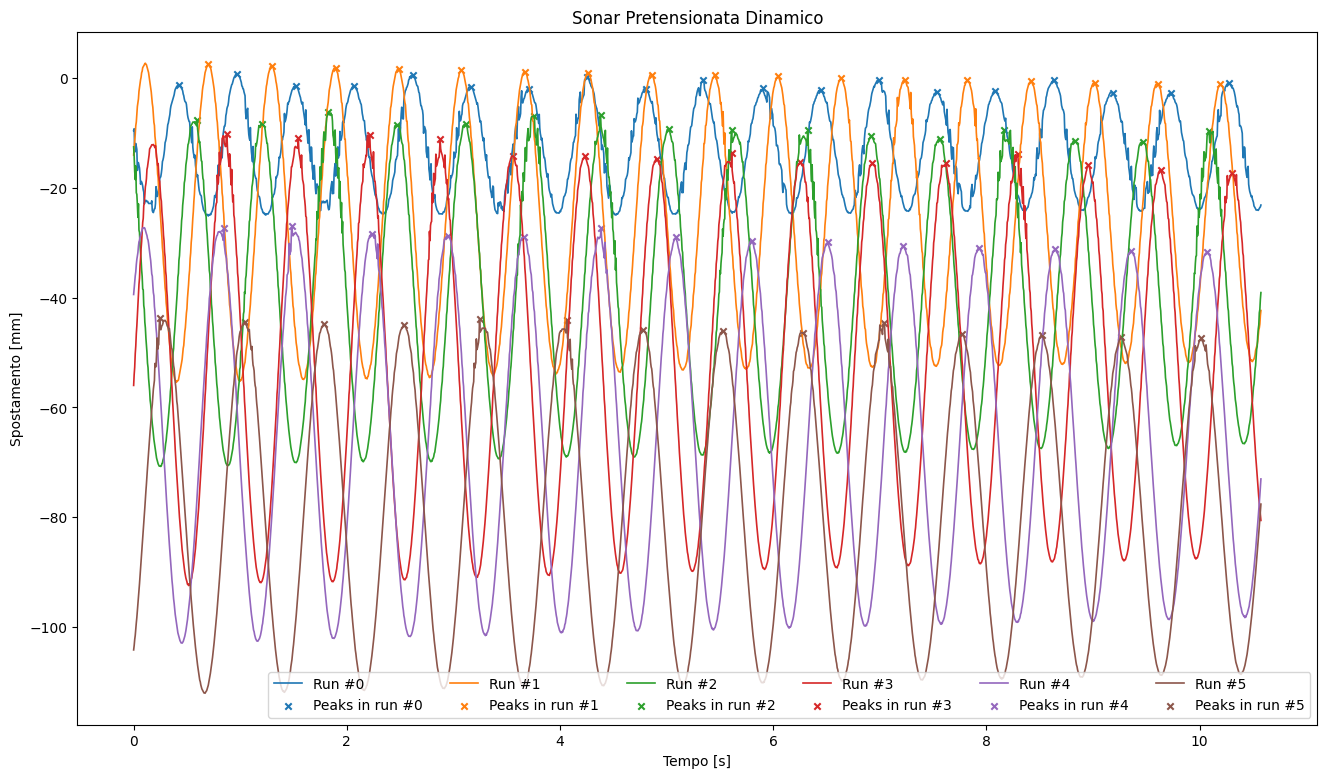

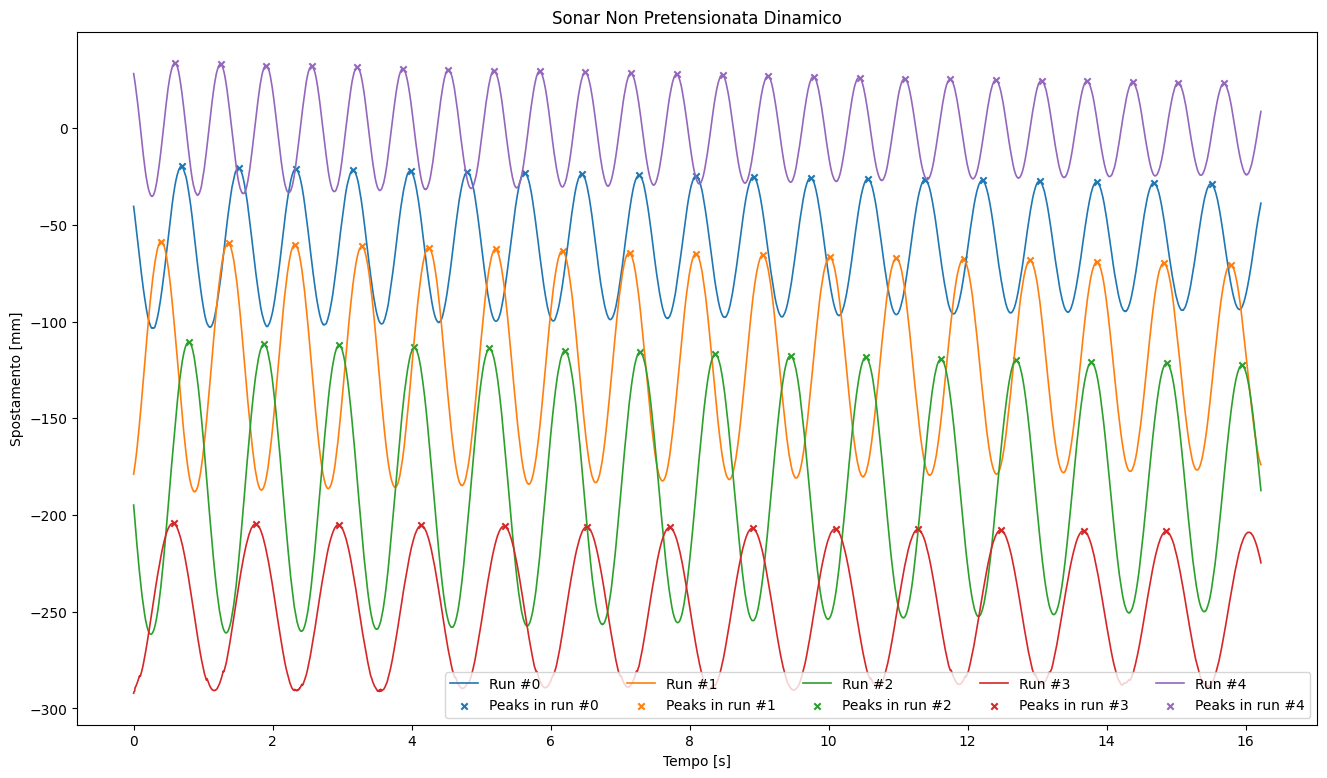

In [756]:
def plot_oscillations(dataset_name):
    plt.figure(figsize=(16, 9))
    runs = len(dynamic_datasets[dataset_name].iloc[0, :])
    legend_text = list()
    for j in range(runs):
        _signal = dynamic_datasets[dataset_name].iloc[:, j].array.tolist()
        _peaks, _ = spy.find_peaks(_signal, width=50)

        plt.plot(
            [i / dynamic_sampling_frequency for i in range(len(_signal))],
            _signal,
            lw=1.2,
        )
        plt.scatter(
            [x / dynamic_sampling_frequency for x in _peaks],
            [_signal[x] for x in _peaks],
            marker="x",
            s=21,
        )
        legend_text.append(f"Run #{j}")
        legend_text.append(f"Peaks in run #{j}")
    plt.title(dataset_name.replace("_", " ").replace("-", " ").title())
    plt.xlabel("Tempo [s]")
    plt.ylabel("Spostamento [mm]")
    plt.legend(legend_text, ncol=runs, loc="lower right")


for data_name in ["sonar_pretensionata_dinamico", "sonar_non-pretensionata_dinamico"]:
    plot_oscillations(data_name)

``results`` in the form of [[$4\pi^2$*mass in kg, squared period in s $^2$], ...]

In [757]:
def analyze_dynamic_dataset(dataset_name: str):
    used_spring = "molla " + dataset_name[6:-9:].replace("-", " ")

    used_masses = dynamic_datasets["masse_" + dataset_name].iloc[:, 0].array.tolist()
    runs = dynamic_datasets[dataset_name]

    print(f"\nDataset: {dataset_name}\nspring: {used_spring}\nmasses: {used_masses}")

    results = np.ndarray((len(runs.columns), 2))

    for idx, run_name in enumerate(runs.columns):
        signal = runs[run_name].array.tolist()

        mean_period, sigma_mean_period = calculate_mean_period(signal)

        results[idx] = [
            4 * math.pi**2 / 1000 * calculate_total_mass(used_masses[idx], used_spring),
            (mean_period / dynamic_sampling_frequency) ** 2,
        ]

    results = np.sort(results, 0)

    print(results, end="\n-----------\n")
    return results


final_dynamic_data = dict()

for key in filter(lambda e: not "masse" in e, dynamic_datasets.keys()):
    final_dynamic_data[key] = analyze_dynamic_dataset(key)


Dataset: sonar_non-pretensionata_dinamico
spring: molla non pretensionata
masses: ['na', 1, '1,2', '1,2,3', '1,2,3,4', '1,2,3,4,5']
[[1.72165379 0.43016489]
 [2.49306207 0.67742045]
 [3.26802341 0.92460244]
 [4.05206478 1.17103316]
 [4.84676533 1.41709184]]
-----------

Dataset: sonar_pretensionata_dinamico
spring: molla pretensionata
masses: ['1,2,3', '1,2,3,4', '1,2,3,4,5', '1,2,3,4,5,6', '1,2,3,4,5,6,7', '1,2,3,4,5,6,7,8', '1,2,3,4,5,6,7,8,9']
[[4.42789932 0.29945216]
 [5.22259986 0.35216807]
 [6.01177343 0.40026711]
 [6.78791912 0.45369847]
 [7.57393442 0.50355399]
 [8.36310799 0.56481006]]
-----------


### Show values

In [758]:
def chi2(expected, observed, yerr):
    if isinstance(yerr, float):
        yerr = np.ones(len(expected)) * yerr
    return np.sum(np.divide(np.square(expected - observed), np.square(yerr)))

In [759]:
def plot_data(set_name: str, values: List[float]) -> None:
    title = set_name.replace("-", " ").replace("_", " ").title()
    y, x = np.array(values[:, 0]), np.abs(np.array(values[:, 1]))

    # set zero correctly
    if set_name == "calibro_non-pretensionata_statico":
        x = np.abs(x - x[-1])

    slope, intercept, r, p, std_err = stat.linregress(x, y)

    expected = slope * x + intercept

    if "statico" in set_name:
        if "calibro" in set_name:
            sigma_x = 0.02 / 1000  # in m
        else:
            sigma_x = 0.2 / 1000  # in m
        sigma_y = 9.805 * 0.01 / 1000  # in N

        mean_x, mean_y = np.mean(x), np.mean(y)
        sigma_k = math.sqrt(
            (1 / mean_x) ** 2
            * (
                (sigma_x * mean_y / mean_x) ** 2
                + sigma_y**2
                # - 2 * mean_y / mean_x * r * sigma_x * sigma_y
            )
        )  # in N/m
        # print(set_name, sigma_k, r, mean_x, mean_y, sigma_x, sigma_y, sep="\n")
    else:
        sigma_x = 2 * np.mean(np.sqrt(x)) / dynamic_sampling_frequency  # in s
        sigma_y = 4 * math.pi**2 * 0.01 / 1000  # in kg

        mean_x, mean_y = np.mean(np.sqrt(x)) ** 2, np.mean(y)
        sigma_k = math.sqrt(
            (1 / mean_x)
            * (
                (sigma_x * 2 * mean_y / mean_x) ** 2
                + sigma_y**2
                # - (mean_y / math.pi**2) / mean_x * r * sigma_x * sigma_y
            )
        )  # in N/m

    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.ylabel(
        "Peso delle masse [N]" if "statico" in set_name else r"4$\pi^2\cdot$ massa [kg]"
    )
    plt.xlabel(
        "Allungamenti [m]"
        if "statico" in set_name
        else "Quadrato del Periodo di oscillazione [s$^2$]"
    )

    plt.plot(x, expected, c="r", ls=":")
    plt.errorbar(x, y, xerr=sigma_x, yerr=sigma_y, ls="", c="k", marker="x")
    plt.legend(["Regressione lineare", "Misure effettuate"])
    plt.minorticks_on()
    plt.grid(which="major", ls="-", lw=0.7)
    plt.grid(which="minor", ls="--", lw=0.5)

    chi2red = chi2(expected, y, sigma_k) / (len(expected - 2))

    print(
        f"{title: <36}k: {abs(slope): >6.3f}, sigma_k_propagazione: {sigma_k: >9.6f}, chi2ridotto: {chi2red: >11.4f}"
    )

Sonar Non Pretensionata Statico     k:  3.124, sigma_k_propagazione:  0.007591, chi2ridotto:      0.0115
Sonar Pretensionata Statico         k: 15.192, sigma_k_propagazione:  0.226912, chi2ridotto:      0.0001
Calibro Pretensionata Statico       k: 15.678, sigma_k_propagazione:  0.003287, chi2ridotto:     18.6414
Calibro Non Pretensionata Statico   k:  3.161, sigma_k_propagazione:  0.007618, chi2ridotto:      0.0508
Sonar Non Pretensionata Dinamico    k:  3.165, sigma_k_propagazione:  0.073749, chi2ridotto:      0.0116
Sonar Pretensionata Dinamico        k: 14.978, sigma_k_propagazione:  0.301612, chi2ridotto:      0.0222


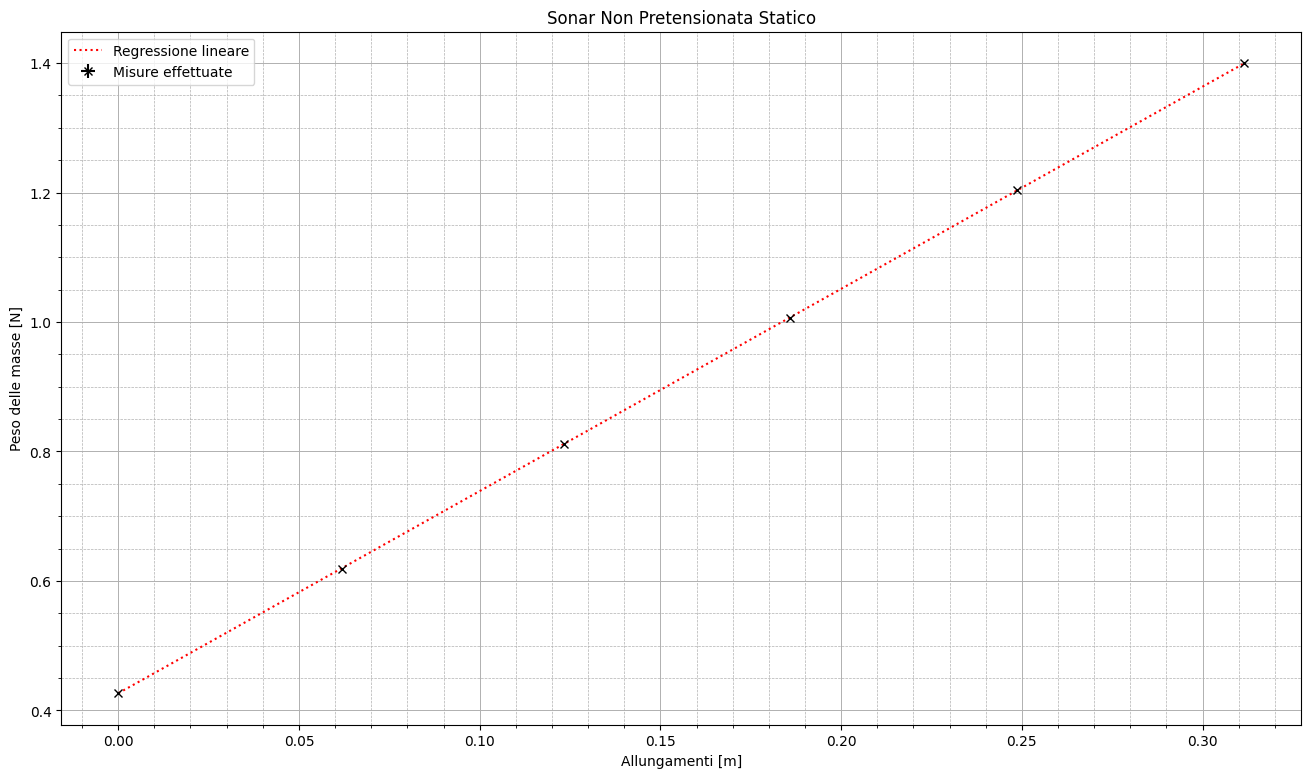

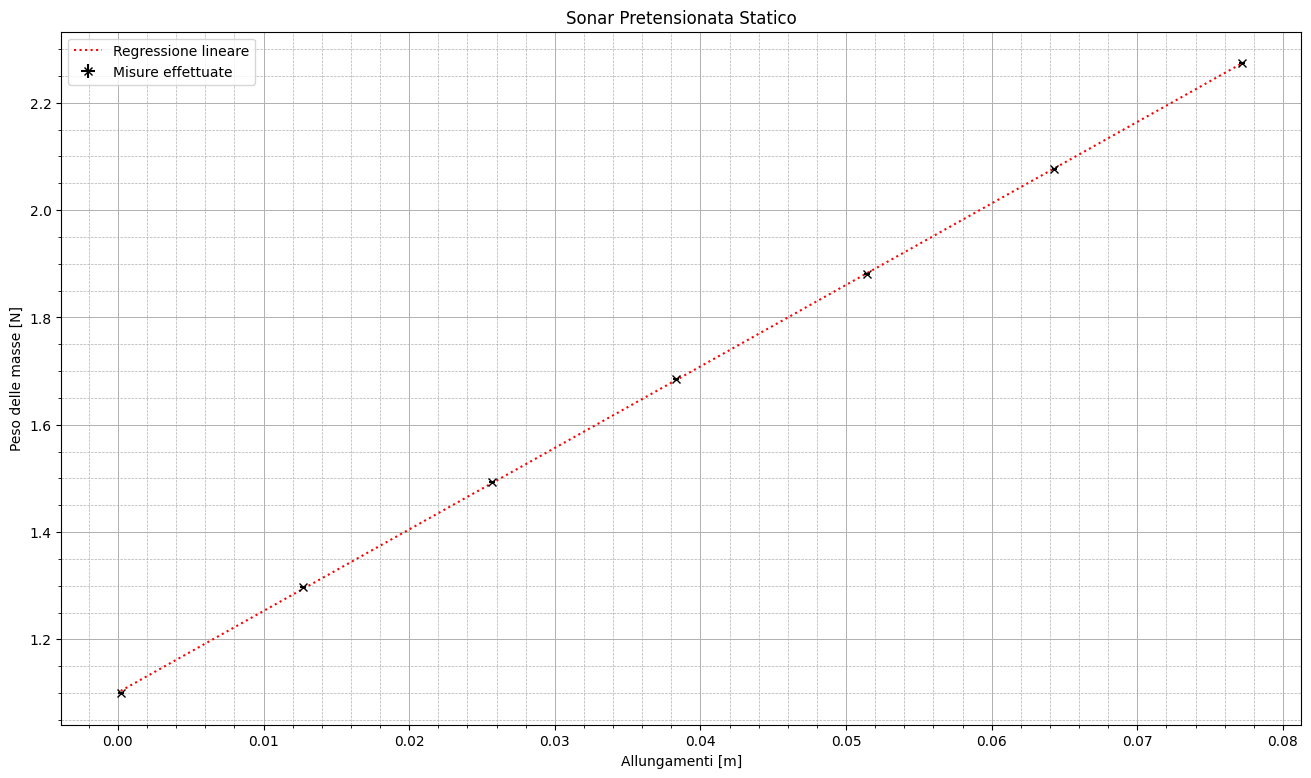

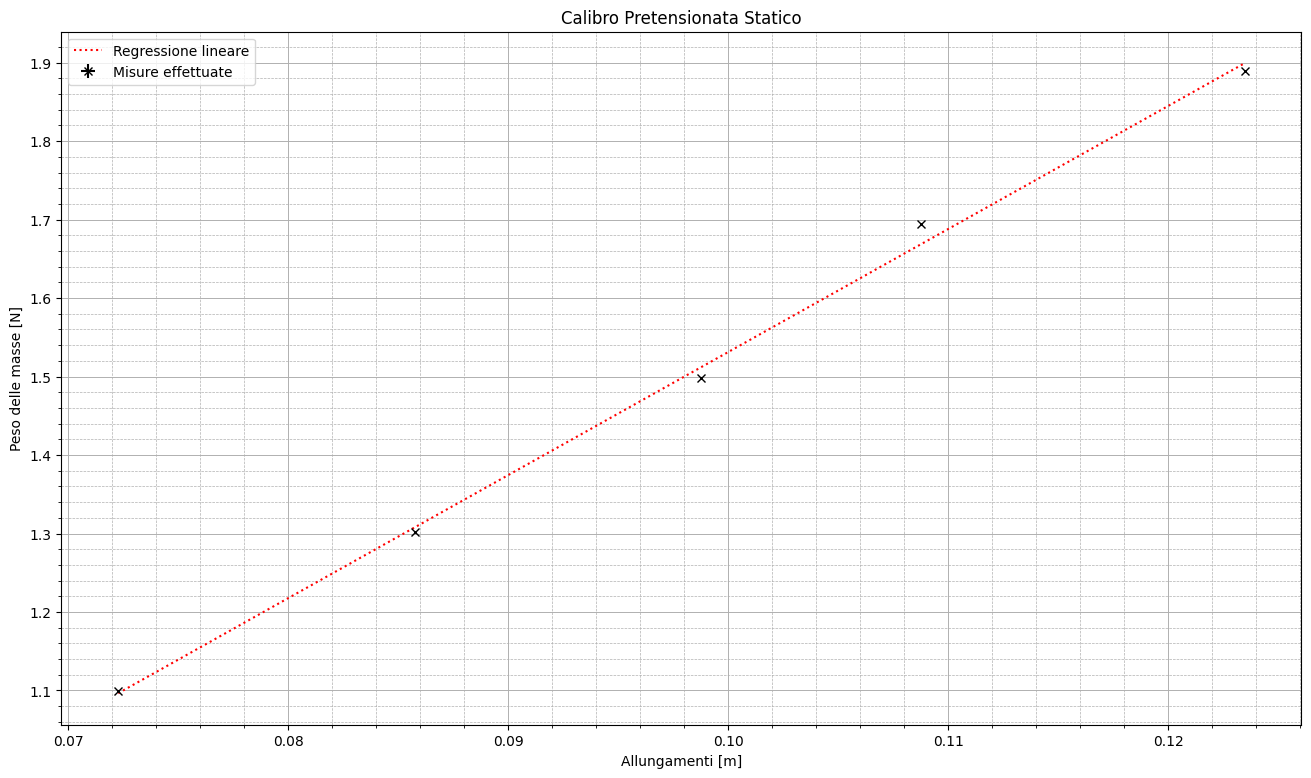

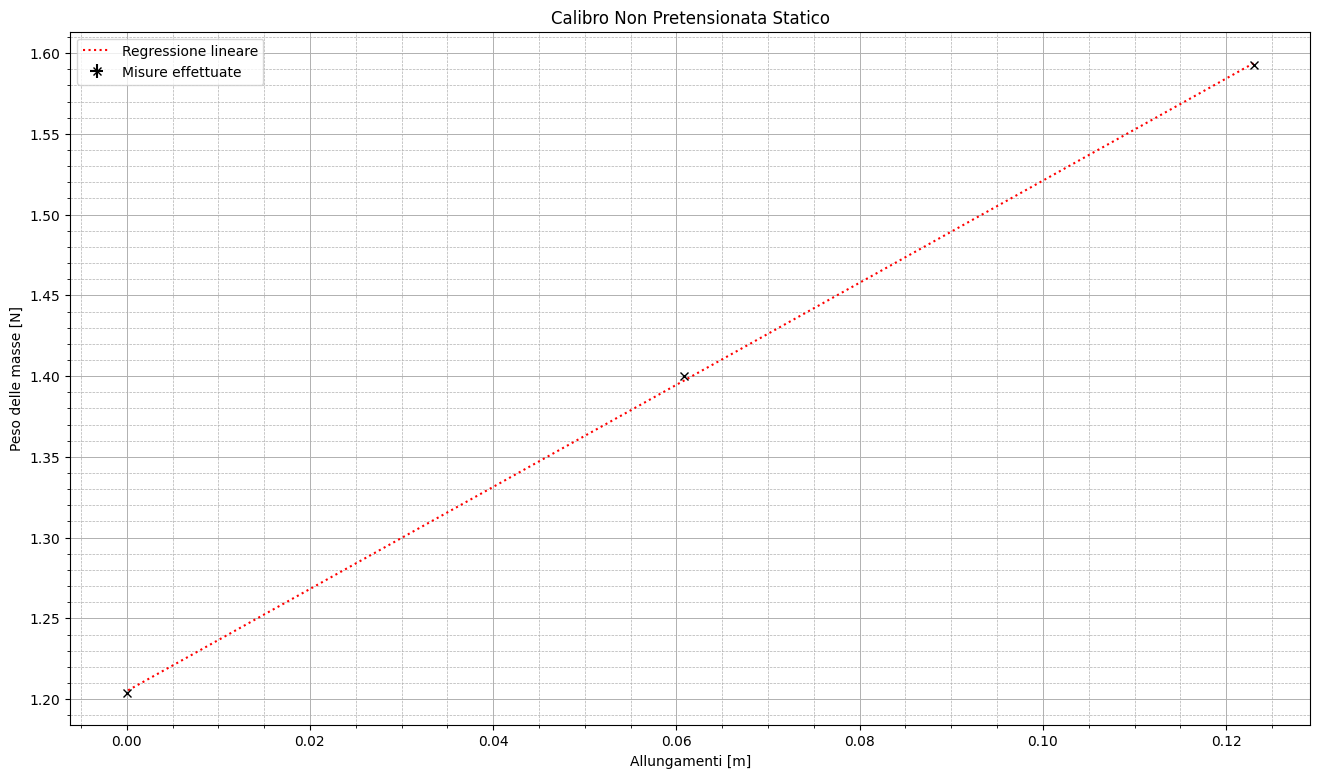

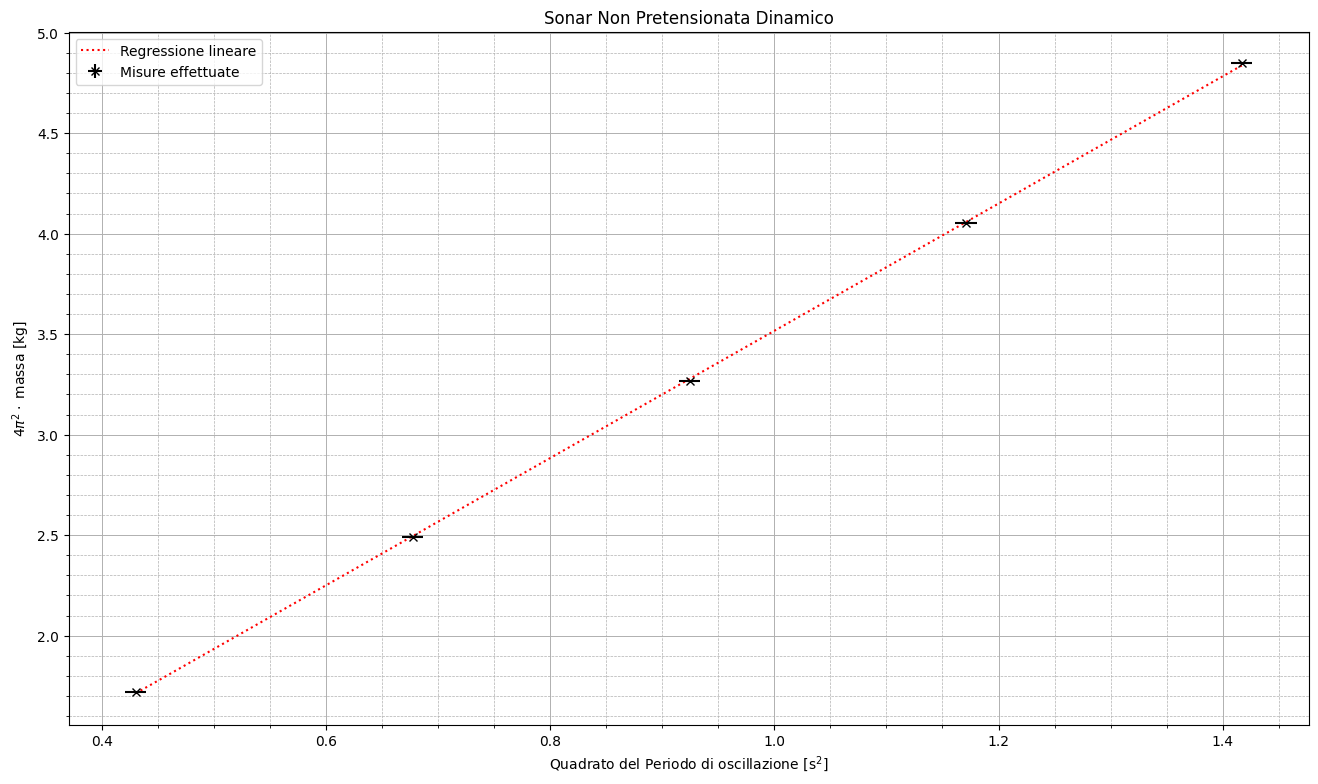

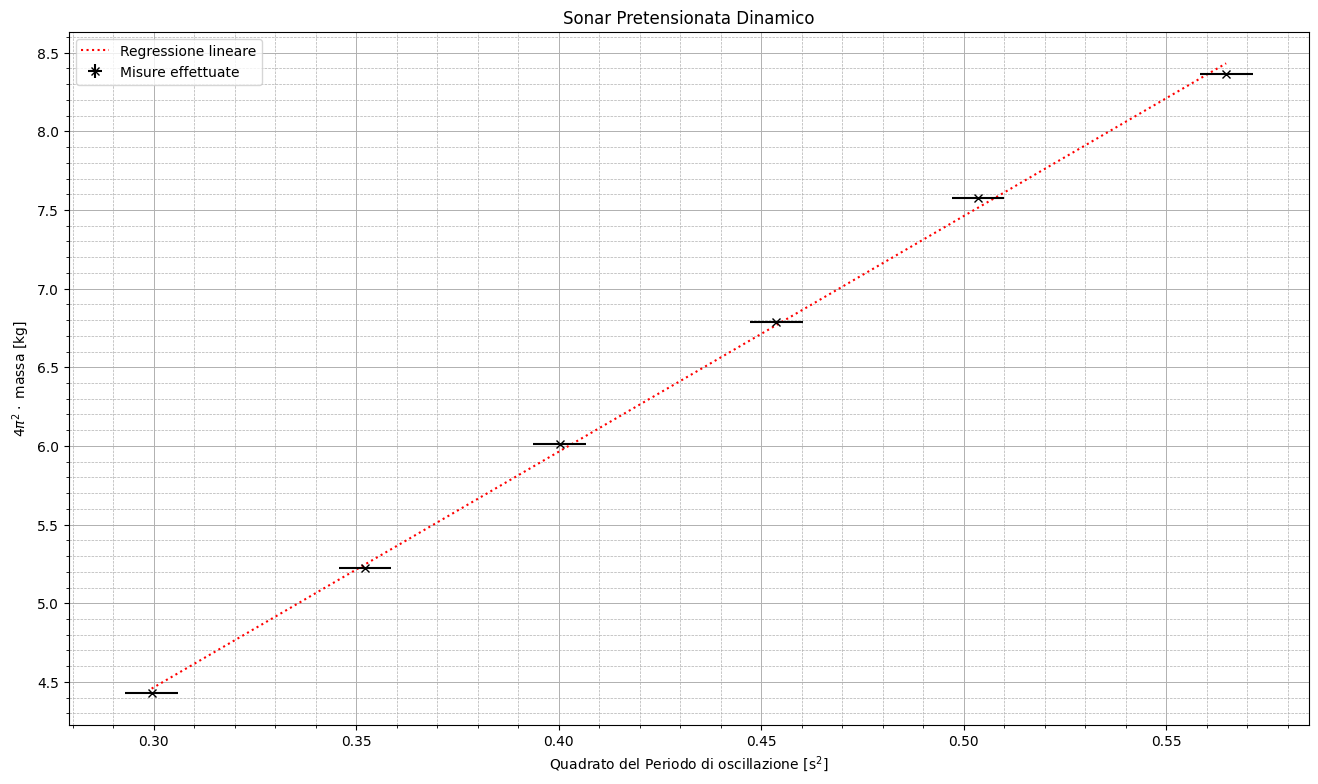

In [760]:
all_final_data = {**final_static_data, **final_dynamic_data}

for set, values in all_final_data.items():
    plot_data(set, values)